## Import Packages

In [1]:
import numpy as np
import pandas as pd
from pytrends.request import TrendReq
import json
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

### Extract confirmed case numbers for target countries

In [2]:
def extract_target_country_case(filename, country_list):
    covid_all = pd.read_csv(filename)
    covid_target = covid_all[covid_all['Country/Region'].isin(country_list)]
    covid_target = covid_target.drop(columns=['Province/State','Lat','Long'])
    # adding up the confirmed case numbers for countires with multiple rows
    for country in country_list:
        covid_multiple_rows = covid_target[covid_target['Country/Region']==country]
        if covid_multiple_rows.shape[0] > 1:
            covid_target = covid_target.drop(covid_multiple_rows.index)
            covid_single_row = covid_multiple_rows.groupby('Country/Region').sum().reset_index()
            covid_target = covid_target.append(covid_single_row).reset_index(drop=True)
        else:
            continue
    return(covid_target)

In [3]:
filename = "data/time_series_covid19_confirmed_global.csv"
country_dict = {'Taiwan*':'TW', 'Korea, South':'KR', 'Italy':'IT', 'Spain':'ES', 'Czechia':'CZ', 
                     'US':'US', 'Peru':'PE', 'Iran':'IR', 'Australia':'AU', 'South Africa':'ZA'}
country_list = list(country_dict.keys())
confirmed_case_target = extract_target_country_case(filename, country_list)

In [5]:
confirmed_case_target

Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0        Czechia        0        0        0        0        0        0   
1           Iran        0        0        0        0        0        0   
2          Italy        0        0        0        0        0        0   
3   Korea, South        1        1        2        2        3        4   
4           Peru        0        0        0        0        0        0   
5   South Africa        0        0        0        0        0        0   
6          Spain        0        0        0        0        0        0   
7        Taiwan*        1        1        3        3        4        5   
8             US        1        1        2        2        5        5   
9      Australia        0        0        0        0        4        5   

   1/28/20  1/29/20  1/30/20  ...  4/15/20  4/16/20  4/17/20  4/18/20  \
0        0        0        0  ...     6216     6433     6549     6606   
1        0        0        0  ...    76389    77995    79494    80868   
2        0        0        0  ...   165155   168941   172434   175925   
3        4        4        4  ...    10591    10613    10635    10653   
4        0        0        0  ...    11475    12491    13489    14420   
5        0        0        0  ...     2506     2605     2783     3034   
6        0        0        0  ...   177644   184948   190839   191726   
7        8        8        9  ...      395      395      395      398   
8        5        5        5  ...   636350   667592   699706   732197   
9        5        6        9  ...     6440     6462     6522     6568   

   4/19/20  4/20/20  4/21/20  4/22/20  4/23/20  4/24/20  
0     6746     6900     7033     7132     7187     7273  
1    82211    83505    84802    85996    87026    88194  
2   178972   181228   183957   187327   189973   192994  
3    10661    10674    10683    10694    10708    10718  
4    15628    16325    17837    19250    20914    21648  
5     3158     3300     3465     3635     3953     4220  
6   198674   200210   204178   208389   213024   219764  
7      420      422      425      426      427      428  
8   758809   784326   811865   840351   869170   905358  
9     6610     6623     6645     6652     6662     6677  

[10 rows x 95 columns]

### Transpose confirmed_case_target dataframe

In [6]:
df_country = pd.DataFrame(country_dict.items(), columns=['Name','Code'])
confirmed_case_target = pd.merge(confirmed_case_target, df_country, how='left', left_on='Country/Region', right_on='Name')
confirmed_case_tr = confirmed_case_target.transpose()

# set country code as the column names of the transposed dataframe
confirmed_case_tr.columns = confirmed_case_tr.loc['Code']
confirmed_case_tr = confirmed_case_tr.drop(['Country/Region','Name','Code'])

# set date as the index of the transposed dataframe
confirmed_case_tr.index = pd.to_datetime(confirmed_case_tr.index)

In [8]:
confirmed_case_tr.tail()

Code          CZ     IR      IT     KR     PE    ZA      ES   TW      US    AU
2020-04-20  6900  83505  181228  10674  16325  3300  200210  422  784326  6623
2020-04-21  7033  84802  183957  10683  17837  3465  204178  425  811865  6645
2020-04-22  7132  85996  187327  10694  19250  3635  208389  426  840351  6652
2020-04-23  7187  87026  189973  10708  20914  3953  213024  427  869170  6662
2020-04-24  7273  88194  192994  10718  21648  4220  219764  428  905358  6677

In [108]:
# (old)only for extracting keywords together
def extract_google_trends(timeframe, keywords_dict):
    timeframe = timeframe[0]+" "+timeframe[1]
    pytrend = TrendReq(hl='en-US', tz=360)
    result_dict = {}
    for key in list(keywords_dict.keys())[:-1]:
        pytrend.build_payload(kw_list=keywords_dict[key], cat=0, timeframe=timeframe, geo=key)
        result_local = pytrend.interest_over_time().drop(columns=['isPartial'])
        if key == 'US':
            result = result_local
        else:
            result_local.columns = [keyword+"(local)" for keyword in keywords_dict['common']]
            pytrend.build_payload(kw_list=keywords_dict['common'], cat=0, timeframe=timeframe, geo=key)
            result_common = pytrend.interest_over_time().drop(columns=['isPartial'])
            result = pd.concat([result_local, result_common], axis=1)
        result['date'] = result.index.strftime("%Y/%m/%d")
        result_dict[key] = result
    return(result_dict)

In [9]:
# extract Google Trends of single(multiple) keyword(s) for each target country
def extract_google_trends(timeframe, keywords_dict, single_search=True):
    timeframe = timeframe[0]+" "+timeframe[1]
    pytrend = TrendReq(hl='en-US', tz=360)
    result_dict = {}
    for key in list(keywords_dict.keys())[:-1]:
        # extract Google Trends of single keyword for each target country
        if single_search:
            result = pd.DataFrame()
            for word in keywords_dict[key]:
                pytrend.build_payload(kw_list=[word], cat=0, timeframe=timeframe, geo=key)
                if pytrend.interest_over_time().empty:
                        result = pd.concat([result, pd.DataFrame(0, index=result.index, columns=[word])], axis=1)
                result = pd.concat([result, pytrend.interest_over_time()], axis=1)
            # extract Google Trends of English keywords for each target country
            if key != 'US':
                result = result.drop(columns=['isPartial'])
                result.columns = [keyword+"(local)" for keyword in keywords_dict['common']]
                for word in keywords_dict['common']:
                    pytrend.build_payload(kw_list=[word], cat=0, timeframe=timeframe, geo=key)
                    result = pd.concat([result, pytrend.interest_over_time()], axis=1)
            result = result.drop(columns=['isPartial'])
            
        # extract Google Trends of multiple keywords for each target country
        else:
            pytrend.build_payload(kw_list=keywords_dict[key], cat=0, timeframe=timeframe, geo=key)
            result_local = pytrend.interest_over_time().drop(columns=['isPartial'])
            if key == 'US':
                result = result_local
            # extract Google Trends of English keywords for each target country
            else:
                result_local.columns = [keyword+"(local)" for keyword in keywords_dict['common']]
                pytrend.build_payload(kw_list=keywords_dict['common'], cat=0, timeframe=timeframe, geo=key)
                result_common = pytrend.interest_over_time().drop(columns=['isPartial'])
                result = pd.concat([result_local, result_common], axis=1)        
        result_dict[key] = result
    return(result_dict)

In [10]:
timeframe = ('2020-01-01', confirmed_case_tr.index.strftime('%Y-%m-%d')[-1])
keywords_dict = {'TW':['武漢', '冠狀病毒', '武漢肺炎', '肺炎', '新冠肺炎'],
                 'KR':['우한', '코로나바이러스', '우한 폐렴', '폐렴', '신종 코로나바이러스'],
                 'IT': ['Wuhan', 'coronavirus', 'Polmonite di Wuhan', 'Polmonite', 'covid'],
                 'ES': ['Wuhan', 'coronavirus', 'neumonía de Wuhan', 'neumonía', 'covid'],
                 'CZ': ['Wu-chan', 'koronavirus', 'wuchanský koronavirus', 'zápal plic', 'covid'],
                 'US':['Wuhan', 'coronavirus', 'Wuhan coronavirus', 'pneumonia', 'covid'],
                 'common':['Wuhan', 'coronavirus', 'Wuhan coronavirus', 'pneumonia', 'covid']}

single_google_trends_dict = extract_google_trends(timeframe, keywords_dict)
multi_google_trends_dict = extract_google_trends(timeframe, keywords_dict, single_search=False)

In [12]:
single_google_trends_dict['ES'].head()

Wuhan(local)  coronavirus(local)  Wuhan coronavirus(local)  \
date                                                                     
2020-01-01             1                   0                         0   
2020-01-02             1                   0                         0   
2020-01-03             1                   0                         0   
2020-01-04             0                   0                         0   
2020-01-05             3                   0                         0   

            pneumonia(local)  covid(local)  Wuhan  coronavirus  \
date                                                             
2020-01-01                17             0      1            0   
2020-01-02                14             0      1            0   
2020-01-03                10             0      1            0   
2020-01-04                19             0      0            0   
2020-01-05                12             0      3            0   

            Wuhan coronavirus  pneumonia  covid  
date                                             
2020-01-01                  0         18      0  
2020-01-02                  0         14      0  
2020-01-03                  0          0      0  
2020-01-04                  0         23      0  
2020-01-05                  0          0      0

### Merge confirmed case dataframe to Google Trends query results
* Reference:
https://thispointer.com/pandas-how-to-merge-dataframes-by-index-using-dataframe-merge-part-3/

In [13]:
for dictionary in [single_google_trends_dict, multi_google_trends_dict]:
    for key in dictionary:
        df_merged = pd.merge(dictionary[key], confirmed_case_tr[key], how='left', left_index=True, right_index=True)
        df_merged[key] = df_merged[key].fillna(0)
        dictionary[key] = df_merged.rename(columns={key:"Confirmed Case"})

In [15]:
single_google_trends_dict['ES'].tail()

Wuhan(local)  coronavirus(local)  Wuhan coronavirus(local)  \
date                                                                     
2020-04-20            15                  23                         0   
2020-04-21            18                  23                         0   
2020-04-22            23                  22                         0   
2020-04-23            18                  21                         0   
2020-04-24            11                  22                         0   

            pneumonia(local)  covid(local)  Wuhan  coronavirus  \
date                                                             
2020-04-20                16            90     15           23   
2020-04-21                26            92     18           23   
2020-04-22                27            92     23           22   
2020-04-23                24            90     18           21   
2020-04-24                23            94     11           22   

            Wuhan coronavirus  pneumonia  covid  Confirmed Case  
date                                                             
2020-04-20                 16         28     90          200210  
2020-04-21                 12         22     92          204178  
2020-04-22                 16         45     92          208389  
2020-04-23                 16         11     90          213024  
2020-04-24                 14         12     94          219764

### Plot Google Trends query results (keywords are extrated together) vs. confirmed case number over time
* Reference:
#### (1) https://seaborn.pydata.org/tutorial/color_palettes.html
#### (2) https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/

In [16]:
def plot_GT_case_trends(t, popularity, country, local=True):
    confirmed_case = popularity['Confirmed Case']
    if local: # when keywords are searched in local language
        popularity = popularity.iloc[:,:5]
        title = "Popularity of Google Search Queries(in local language) & Number of Confirmed Cases Over Time_"+country
    else: # when keywords are searched in English
        popularity = popularity.iloc[:,5:-1]
        title = "Popularity of Google Search Queries(in English) & Number of Confirmed Cases Over Time_"+country
   
    label = list(popularity.columns)
    color = sns.color_palette("husl", len(label))  
    
    # plot Google Trends query trend 
    fig, ax1 = plt.subplots(figsize=(25, 10))
    for i in range(len(label)):    
        ax1.plot(t, popularity.iloc[:,i], color=color[i], label=label[i], linewidth=3)
        
    ax2 = ax1.twinx()
    ax2.plot(t, confirmed_case, color='red', label='# of Confirmed Cases', linewidth=5)

    date_form = mdates.DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.set_ylabel('Popularity of Query', fontsize=20)
    ax2.set_ylabel('Number of Confirmed Cases', fontsize=20, color='red')
    ax1.tick_params(axis='x', labelsize=15, labelrotation=45)
    ax1.tick_params(axis='y', labelsize=15)
    ax2.tick_params(axis='y', labelcolor='red', labelsize=15)
    ax1.grid(linewidth=0.5, color='gray')
    fig.legend(fontsize=15, loc=(0.07,0.7))
    plt.title(title, fontsize=25)
    plt.show()

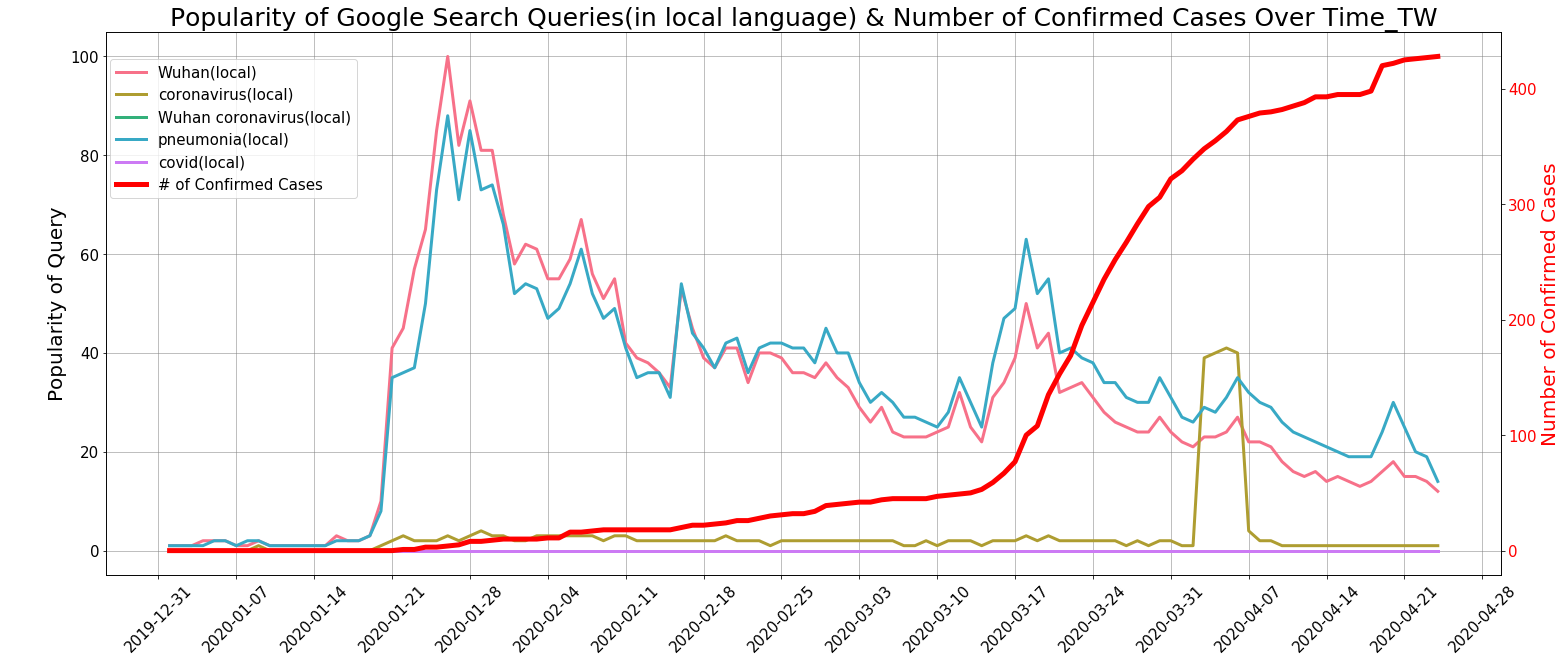

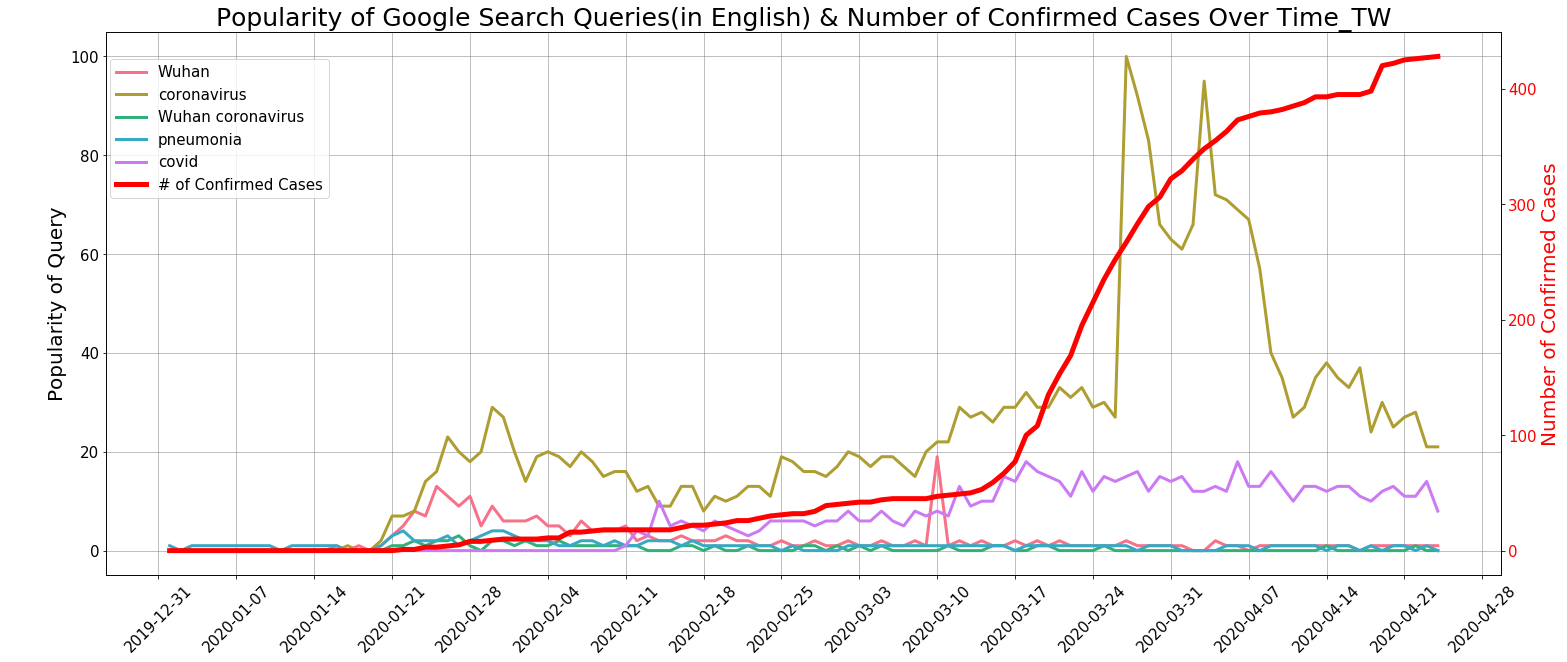

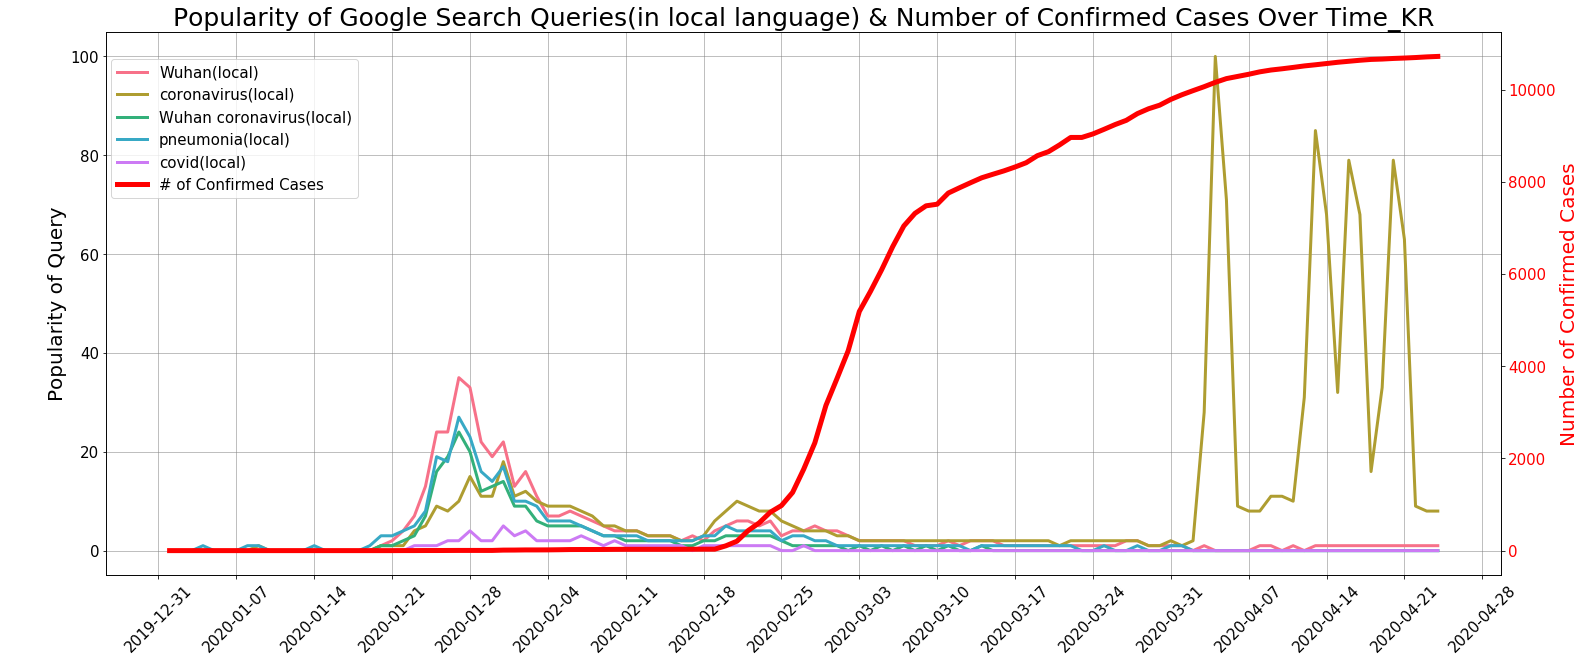

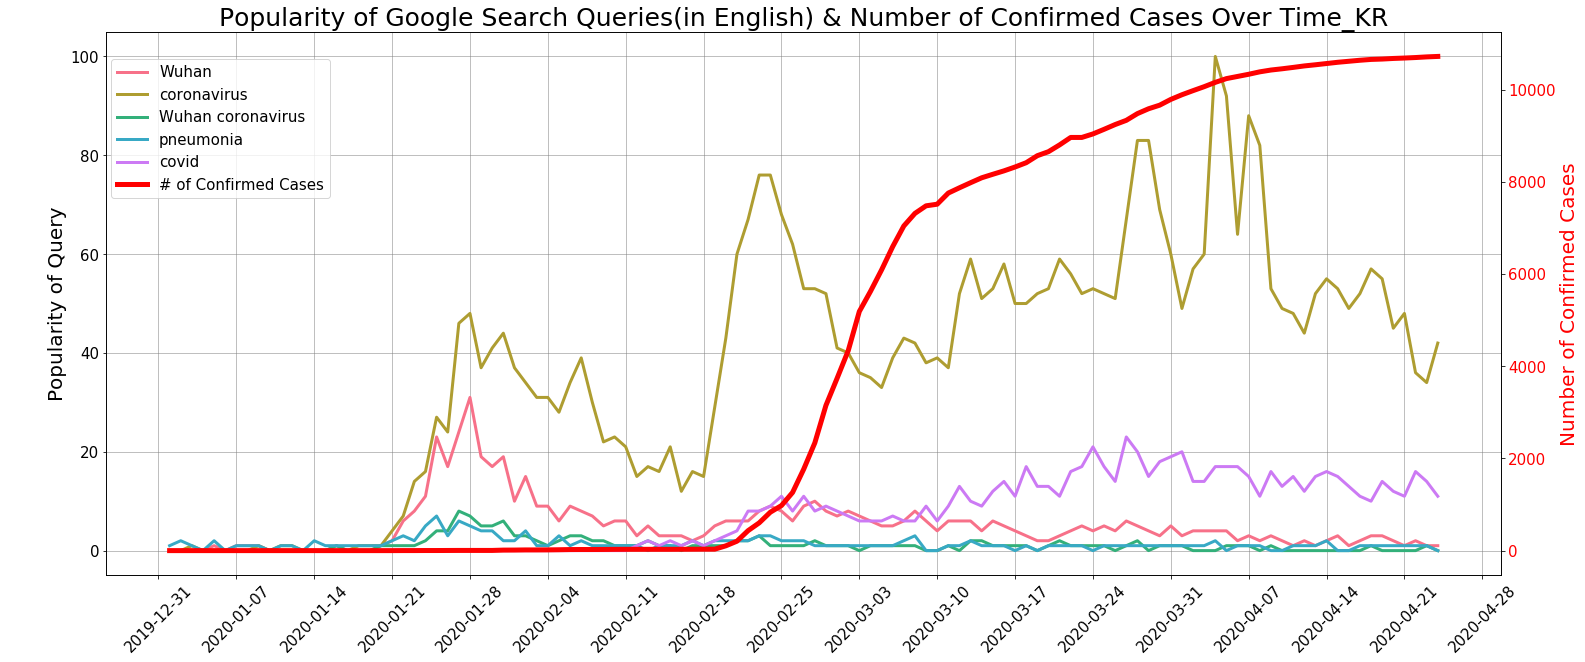

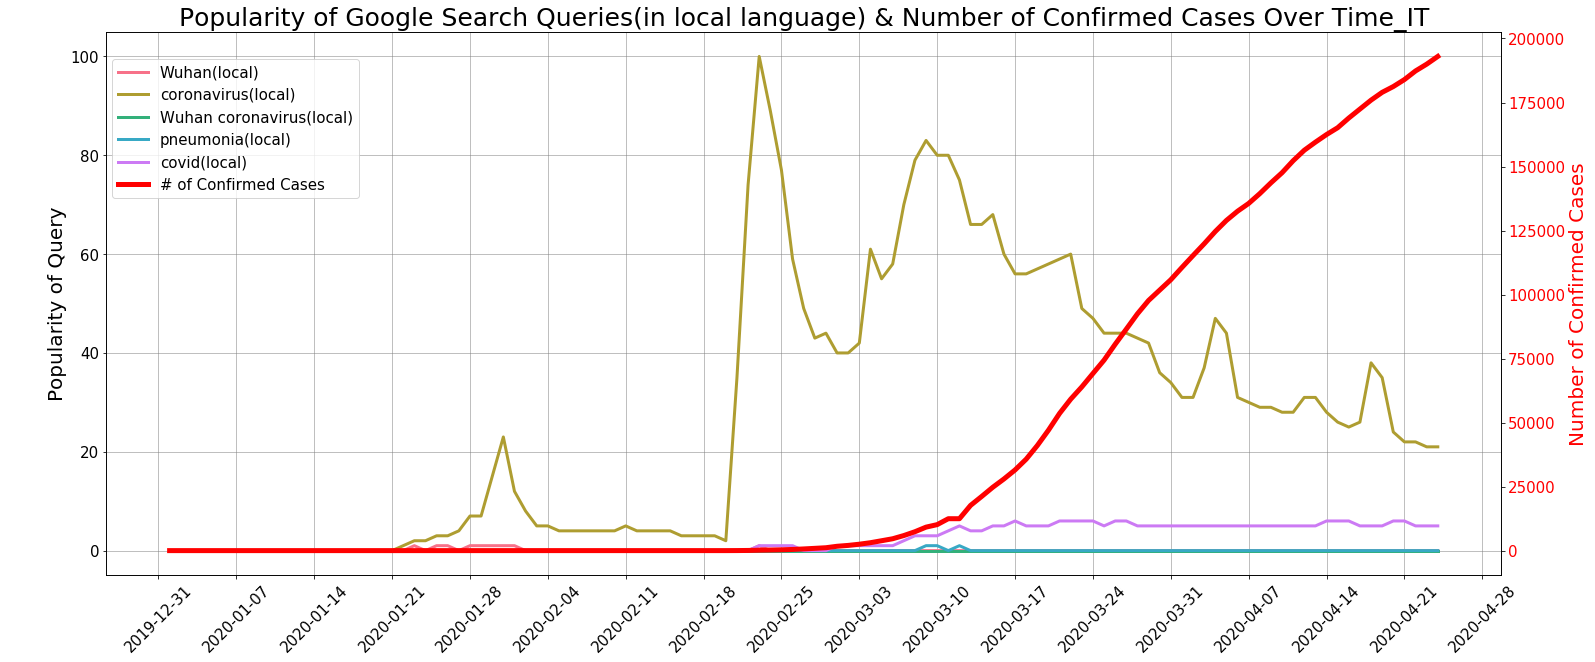

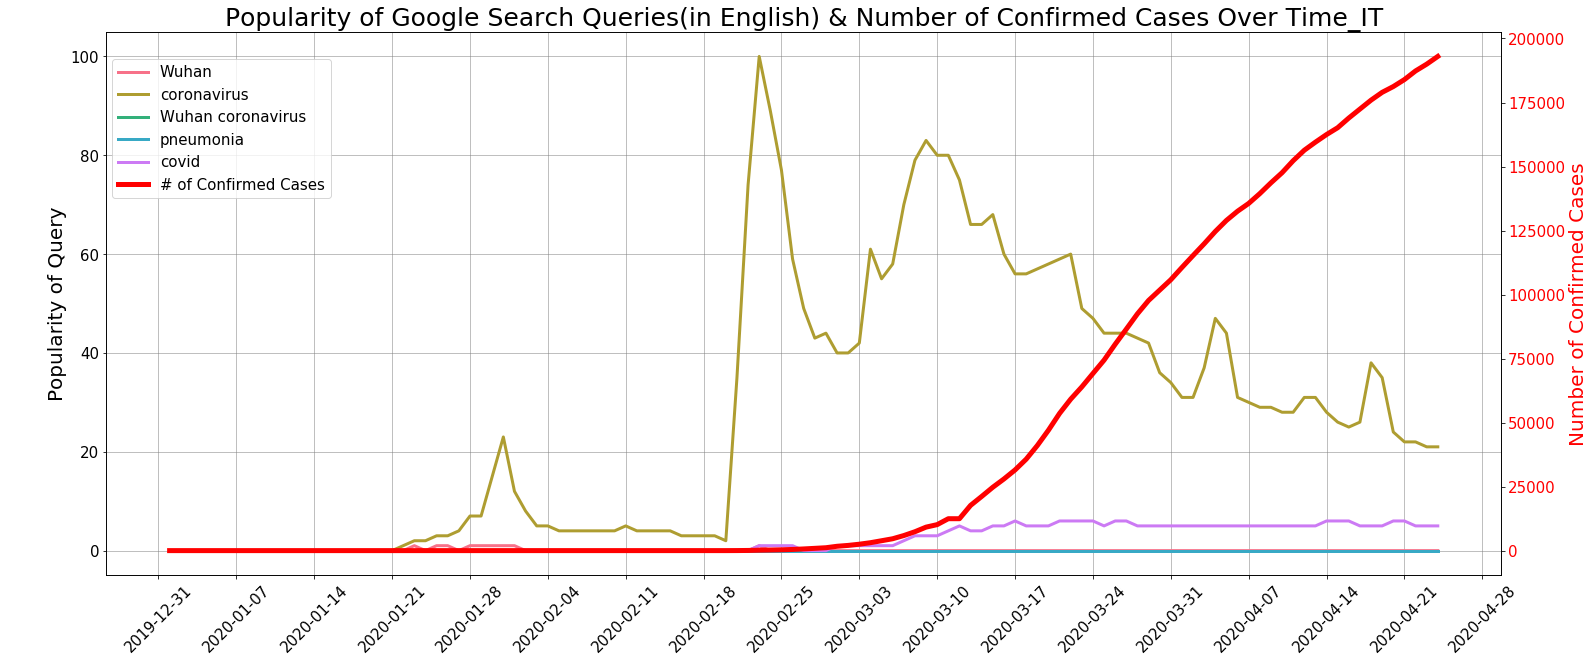

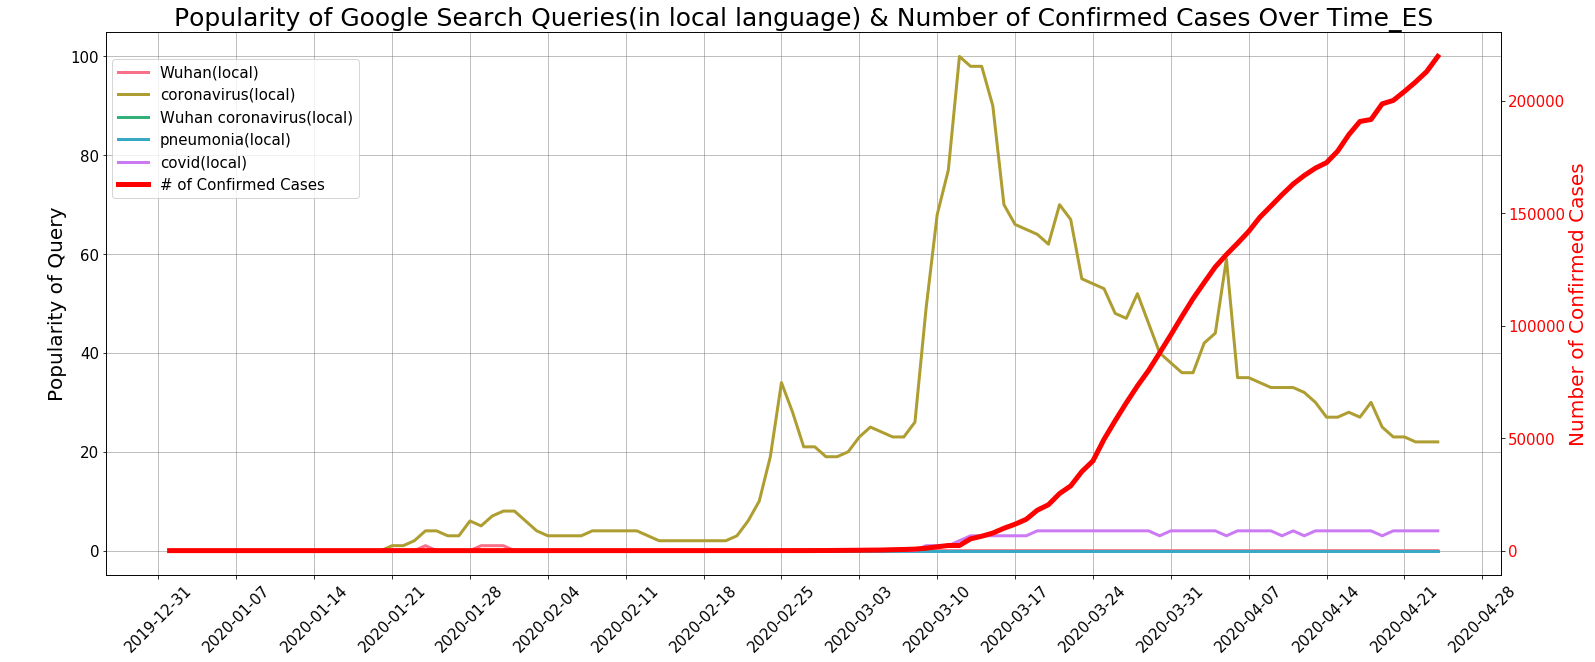

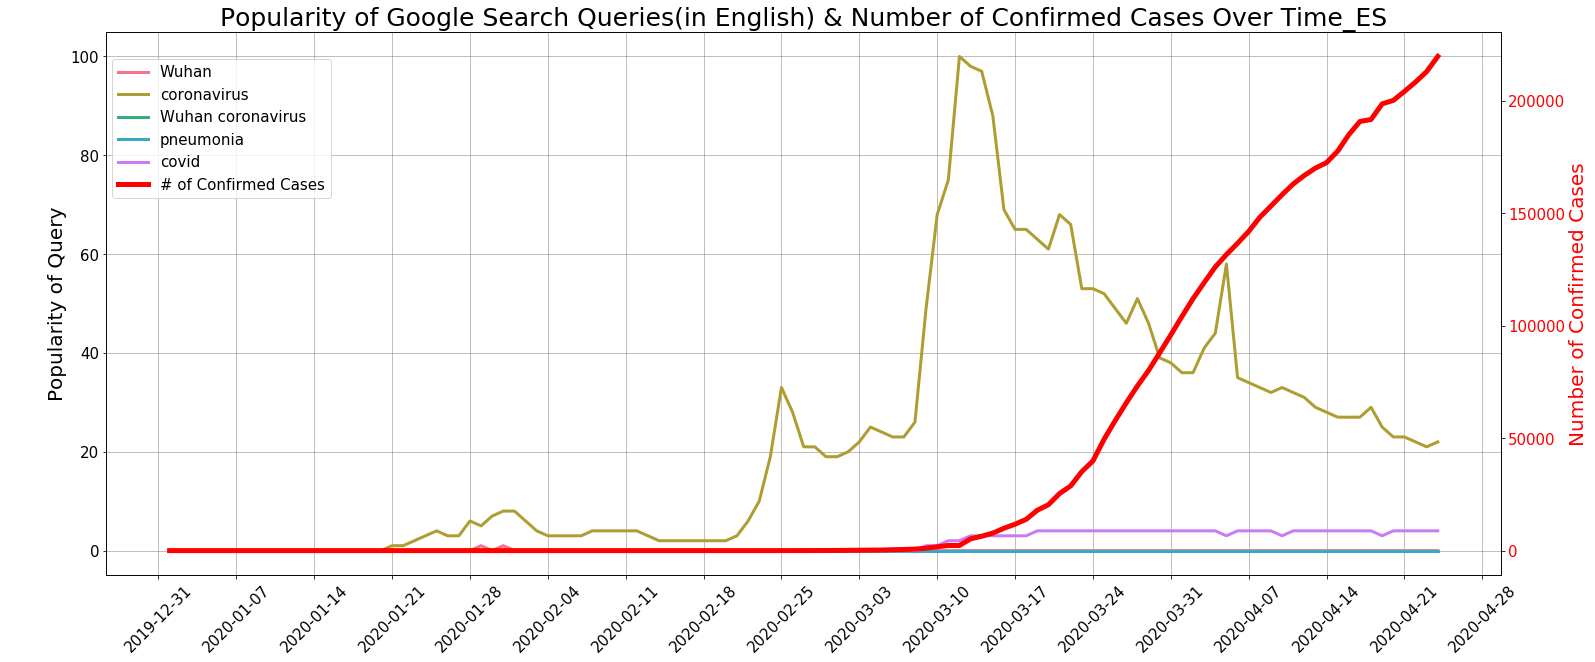

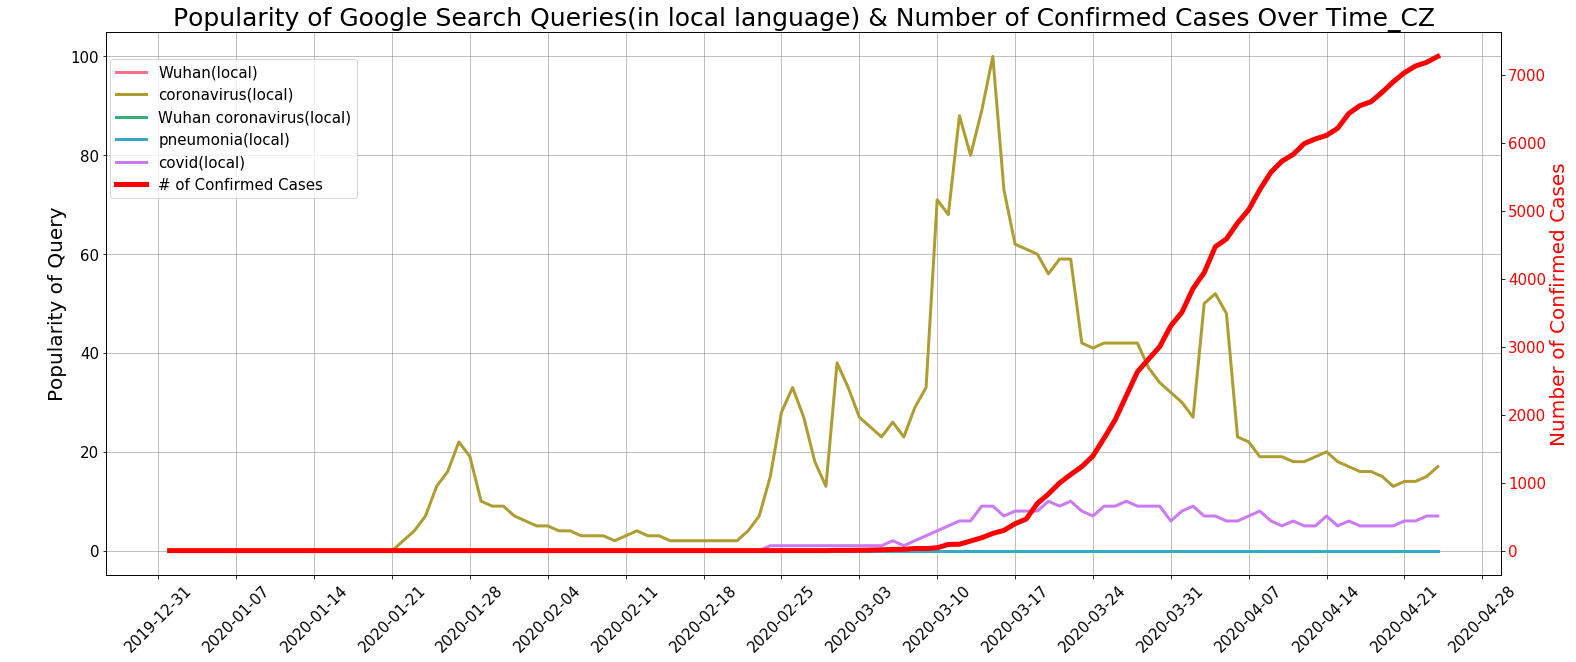

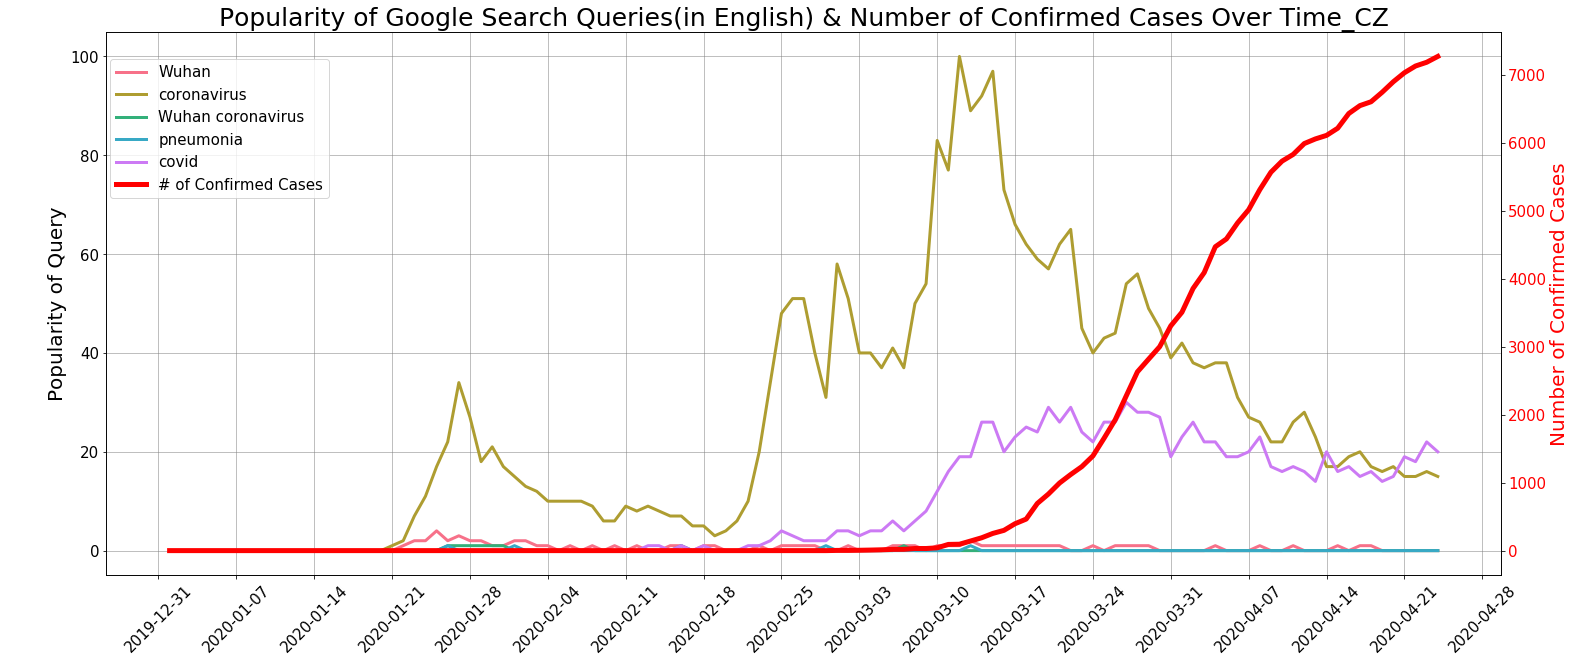

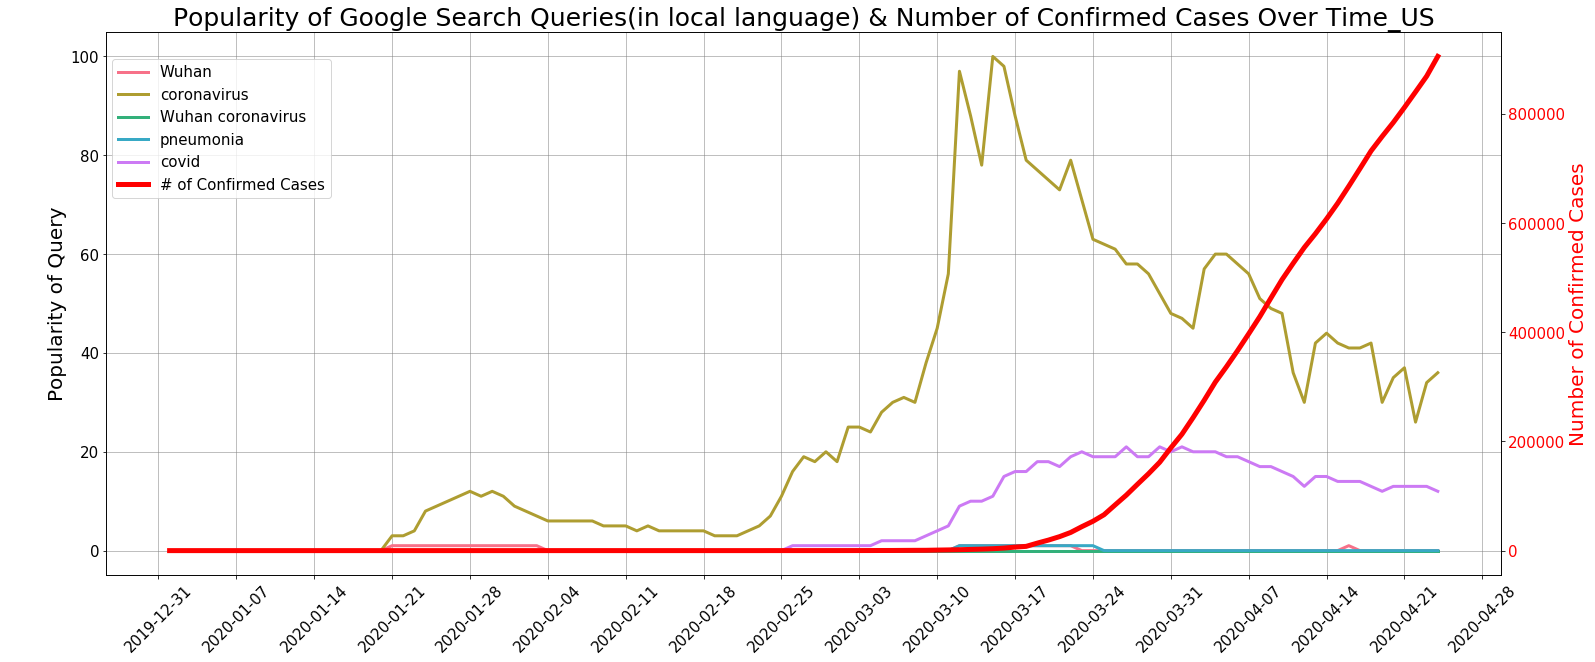

In [20]:
for key in multi_google_trends_dict:
    popularity = multi_google_trends_dict[key]
    t = popularity.index.values
    plot_GT_case_trends(t, popularity, key)
    if key != 'US':
        plot_GT_case_trends(t, popularity, key, local=False)

### Actual searching results on Google Trends website:

<img src="GT_Results/TW_together(local).png">

<img src="GT_Results/KR_together(local).png">

<img src="GT_Results/IT_together(local).png">

<img src="GT_Results/US_together.png">

### Plot Google Trends query results (keywords are extrated individually) vs. confirmed case number over time

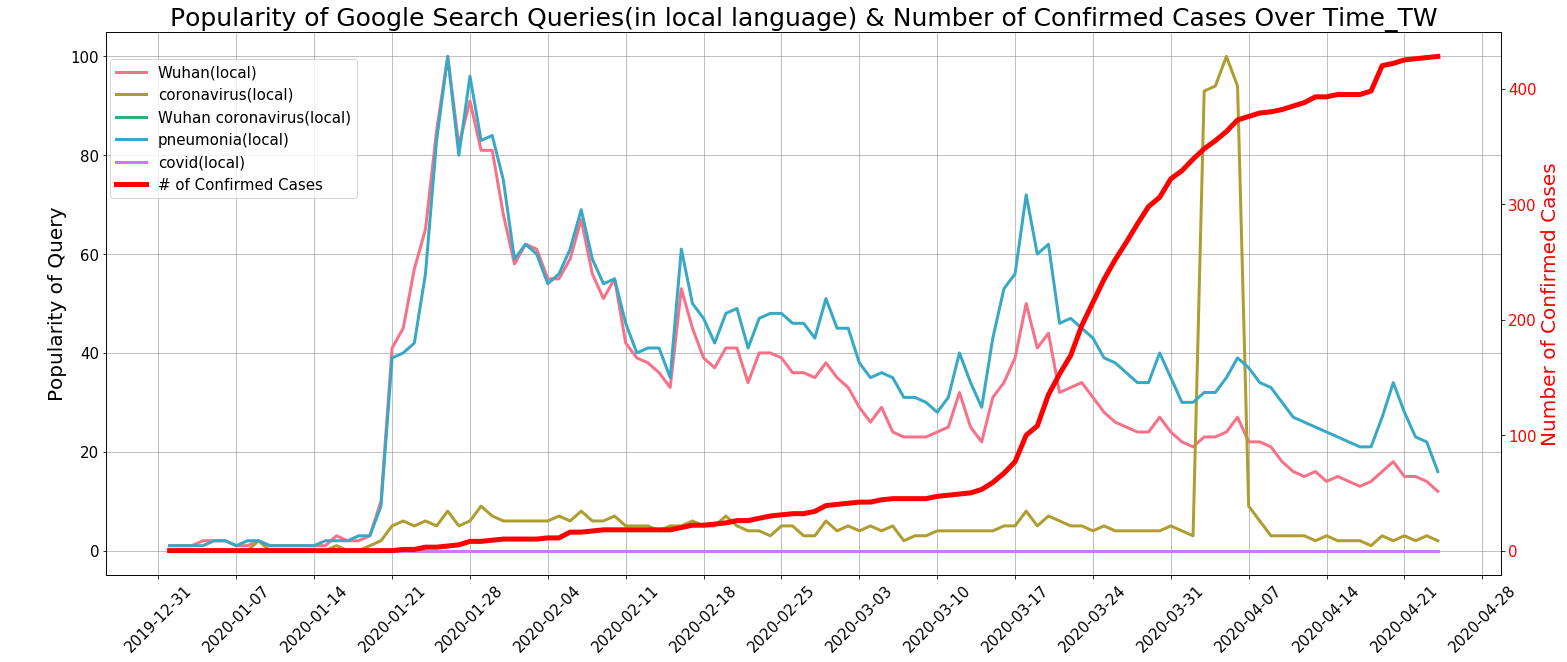

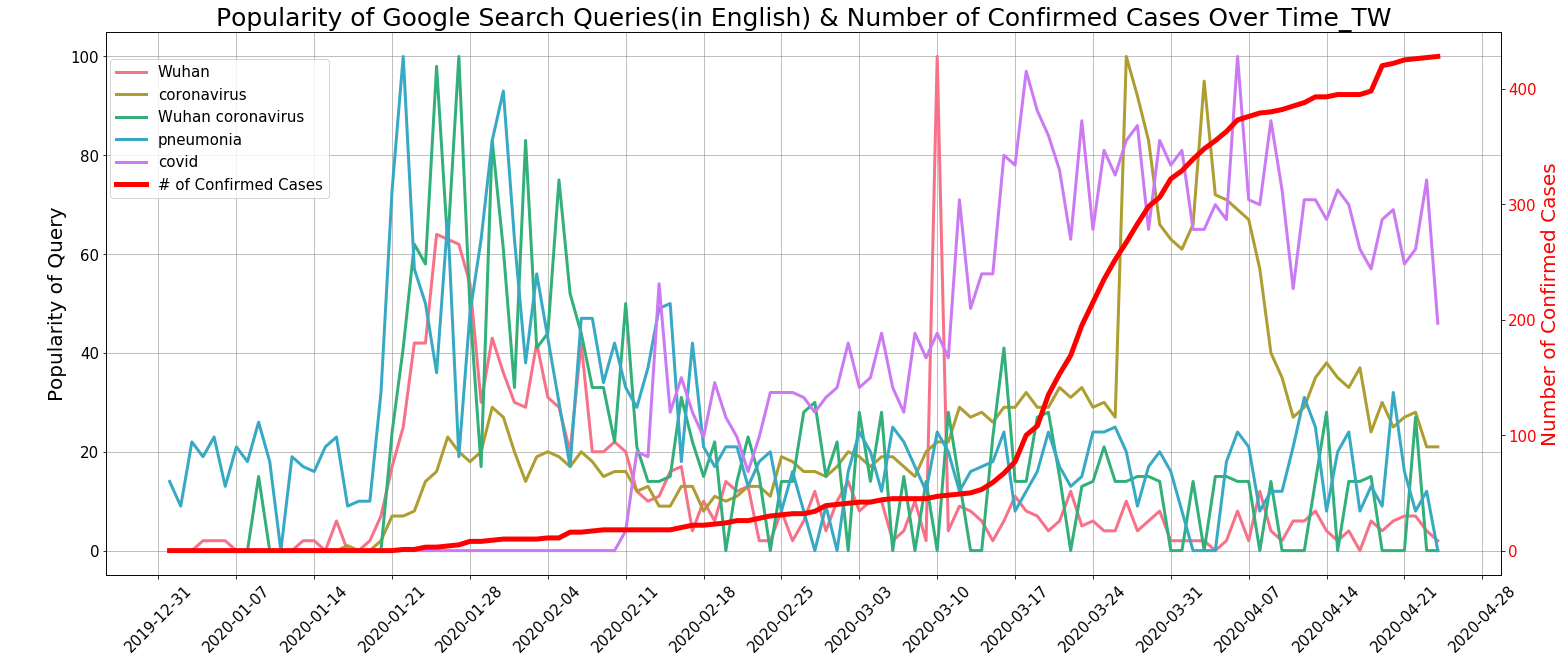

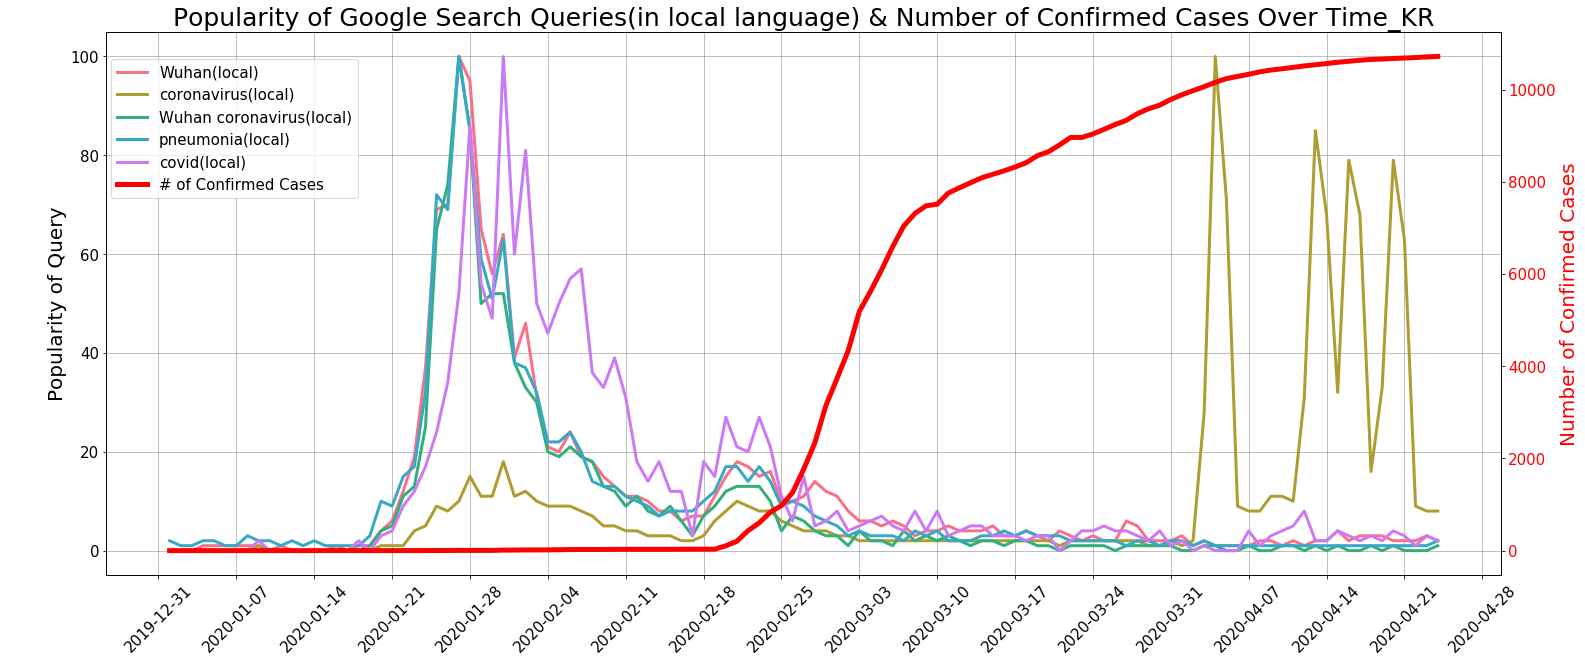

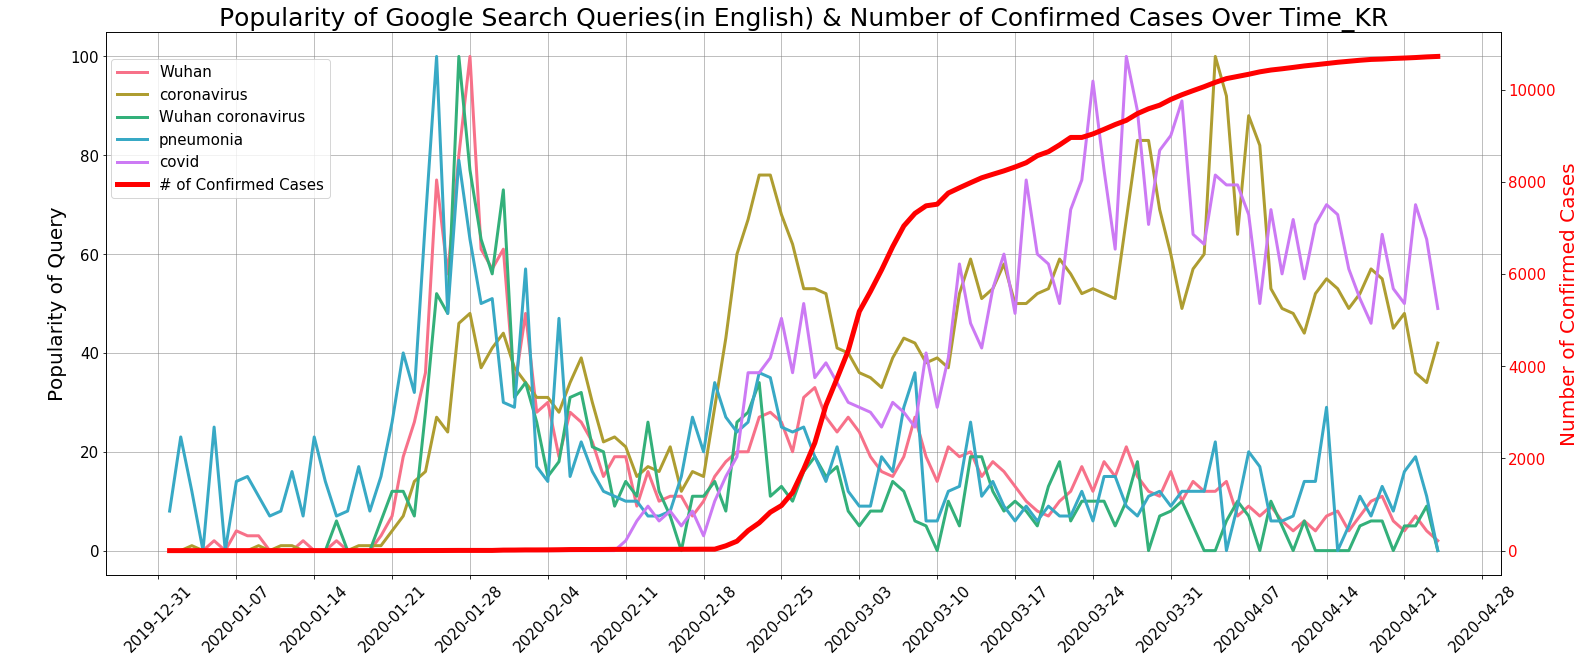

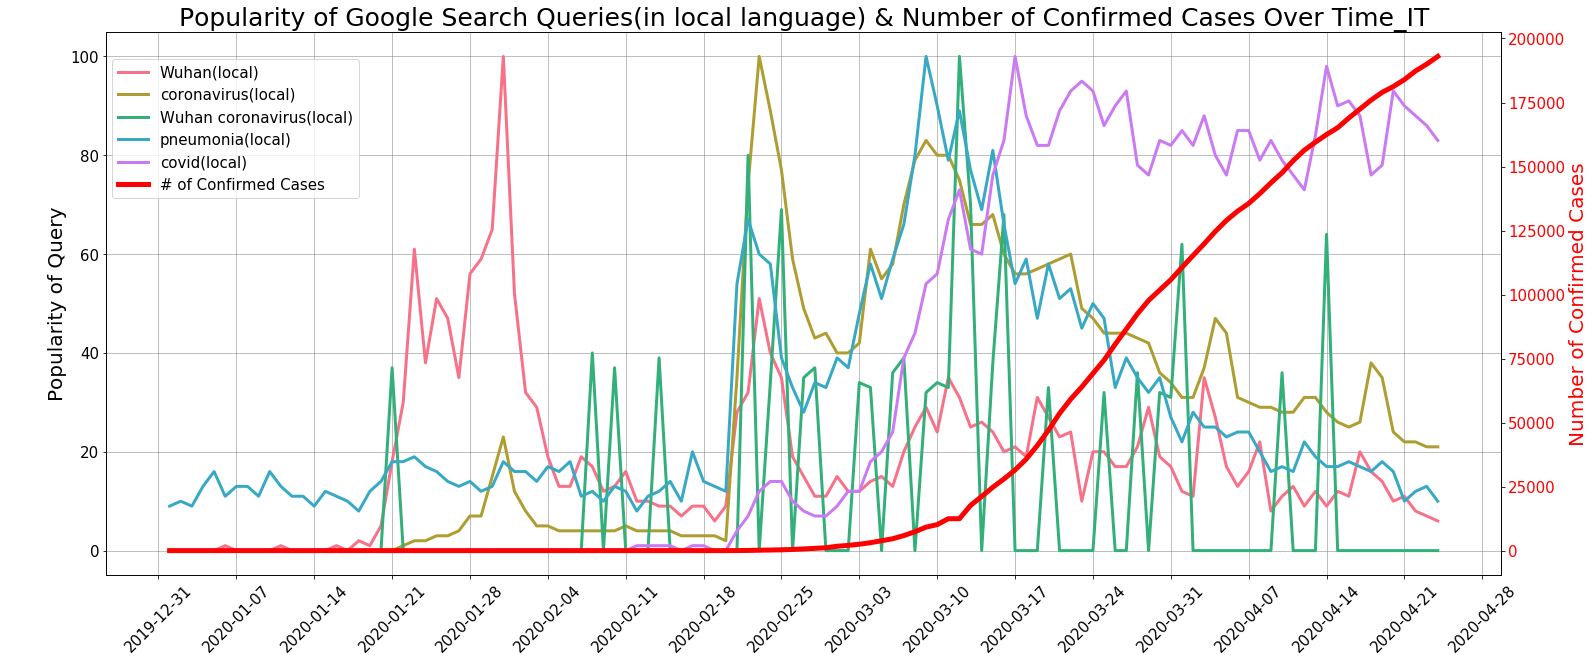

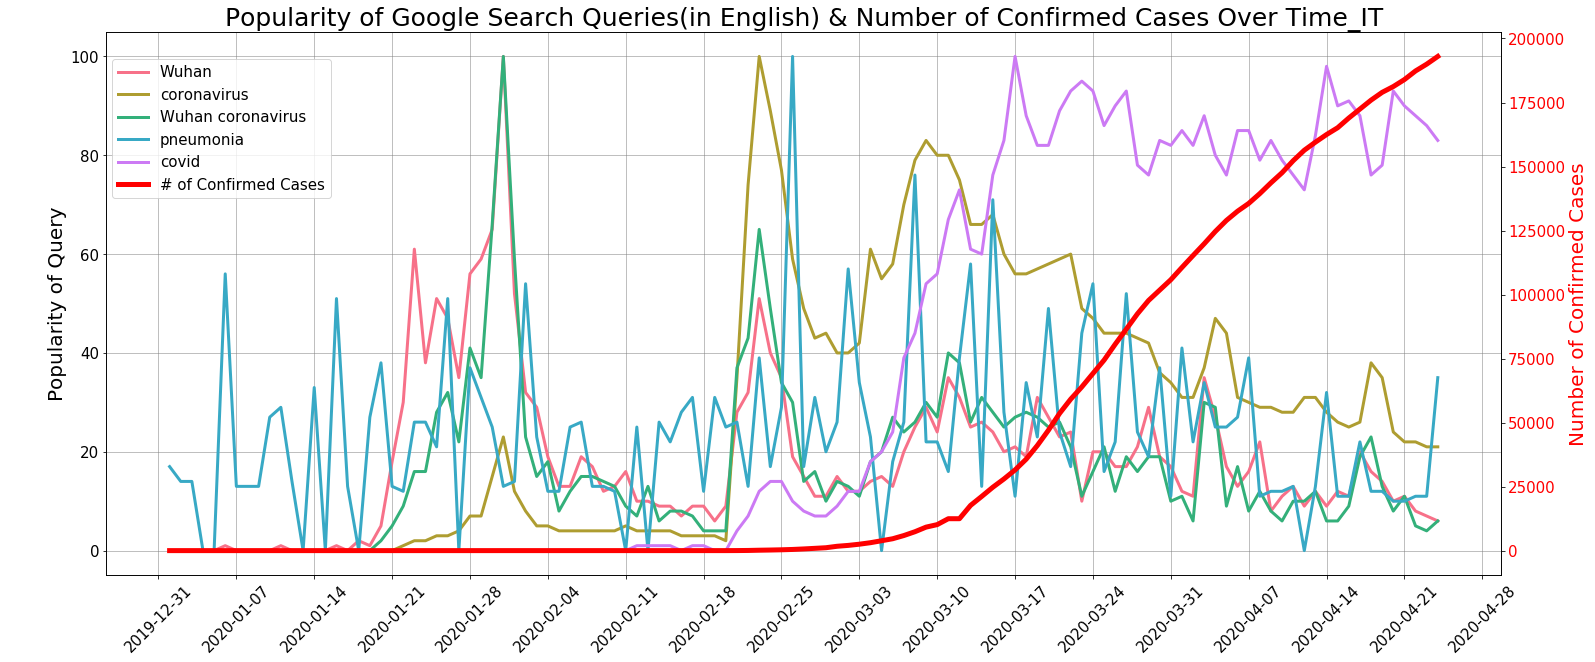

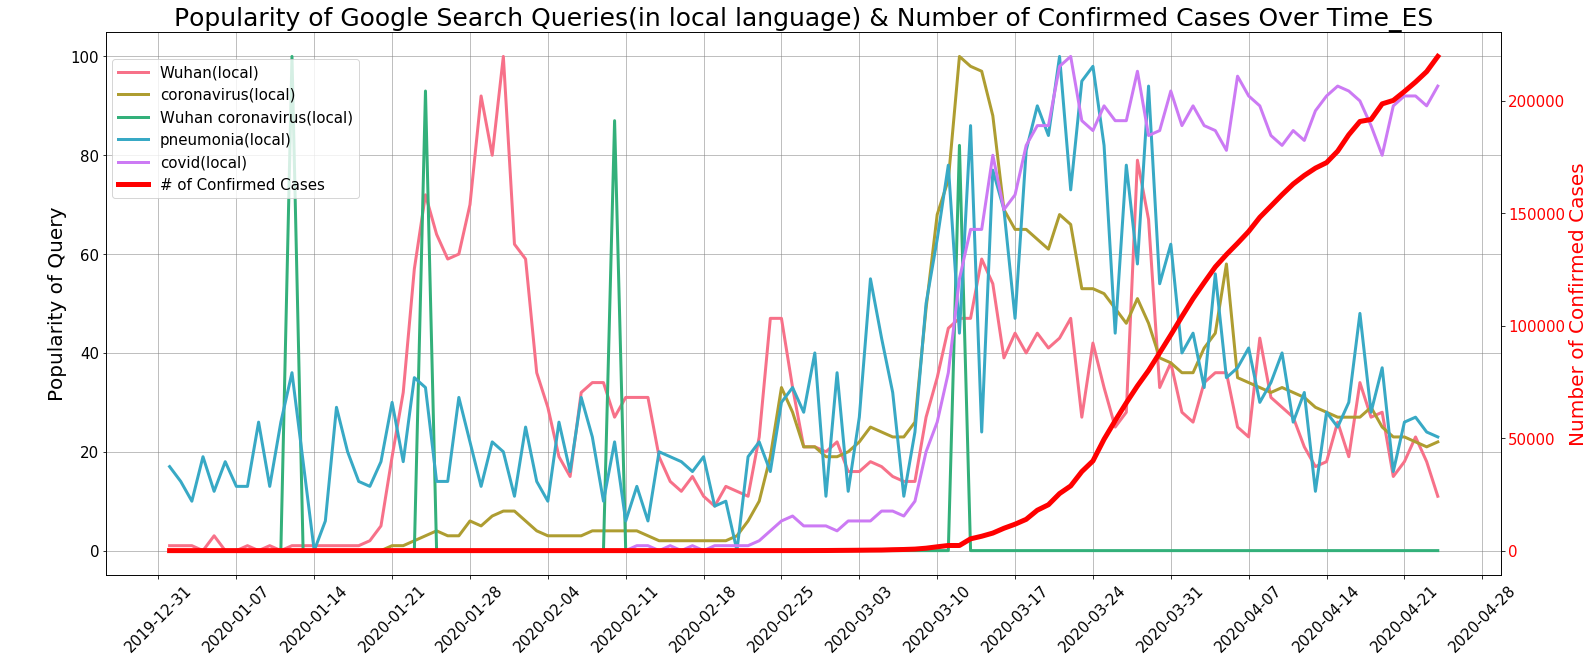

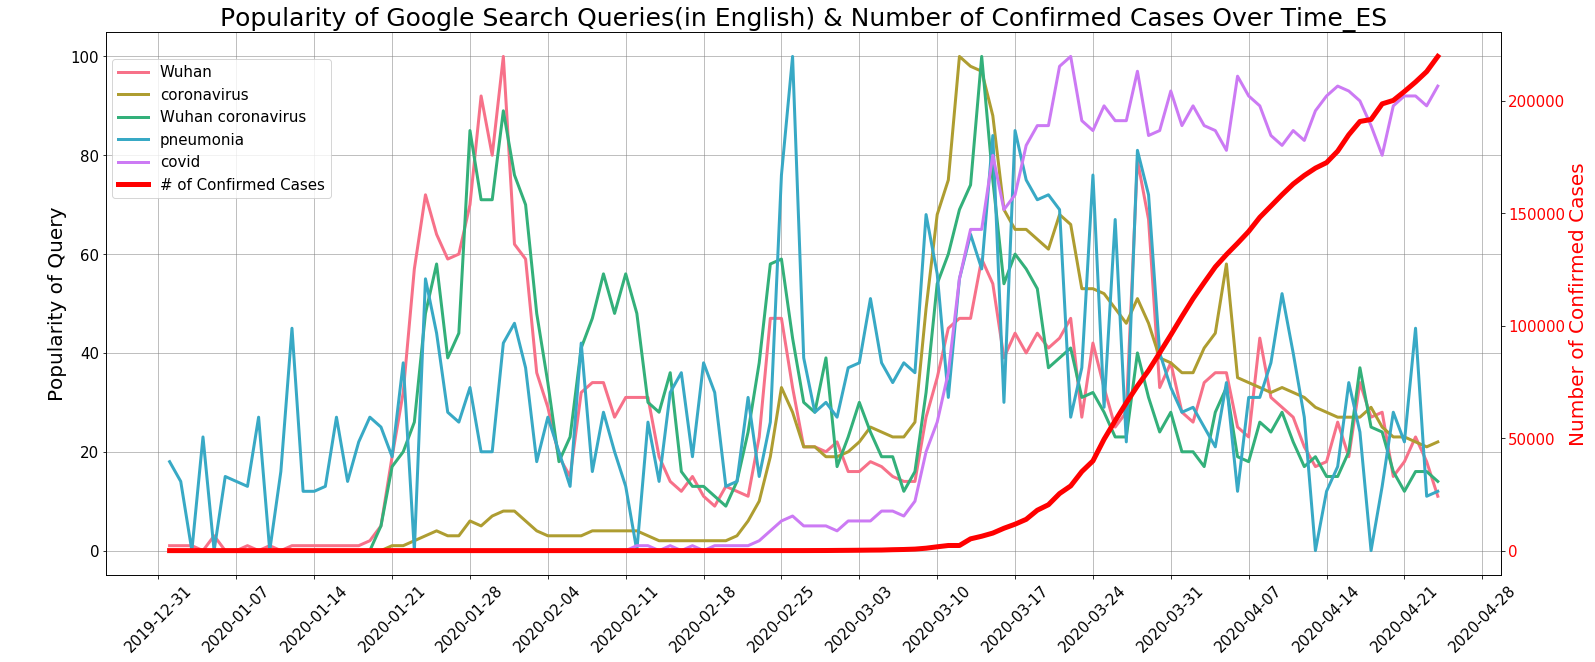

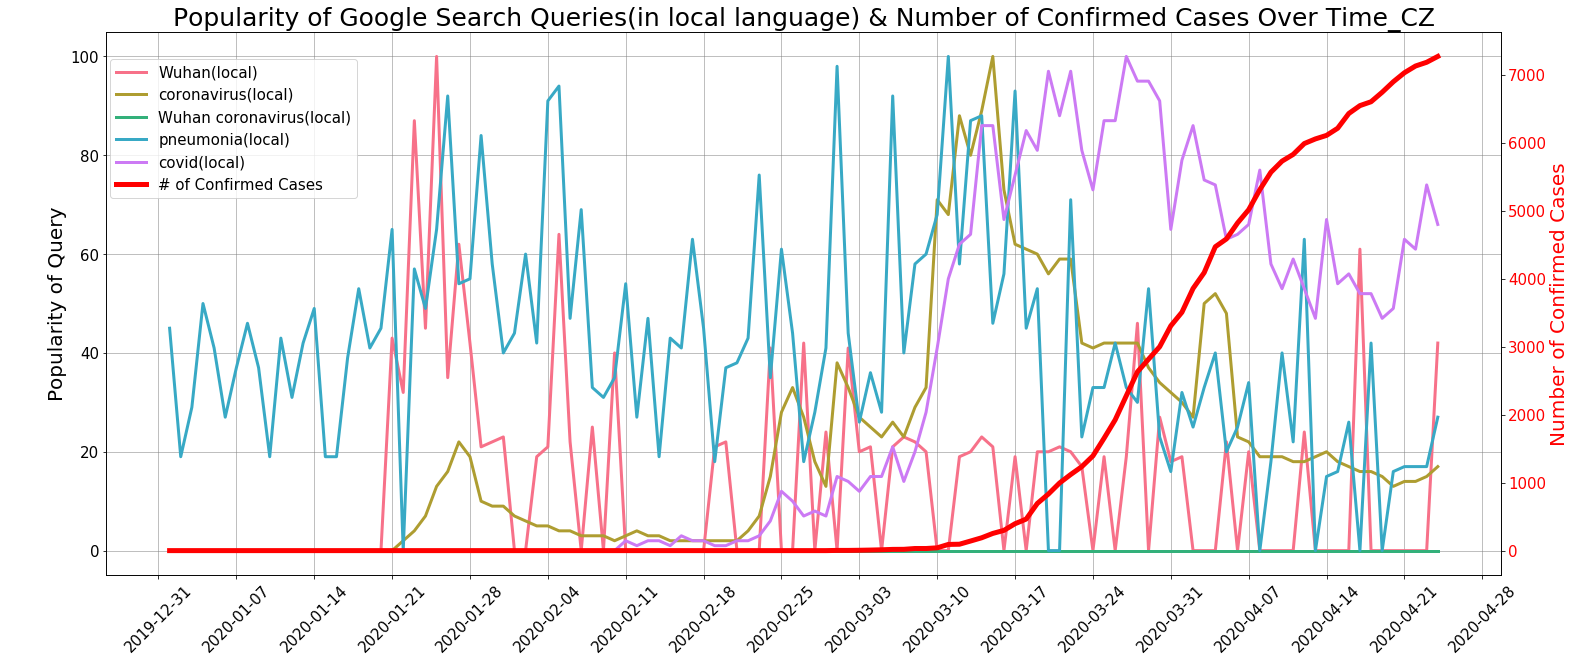

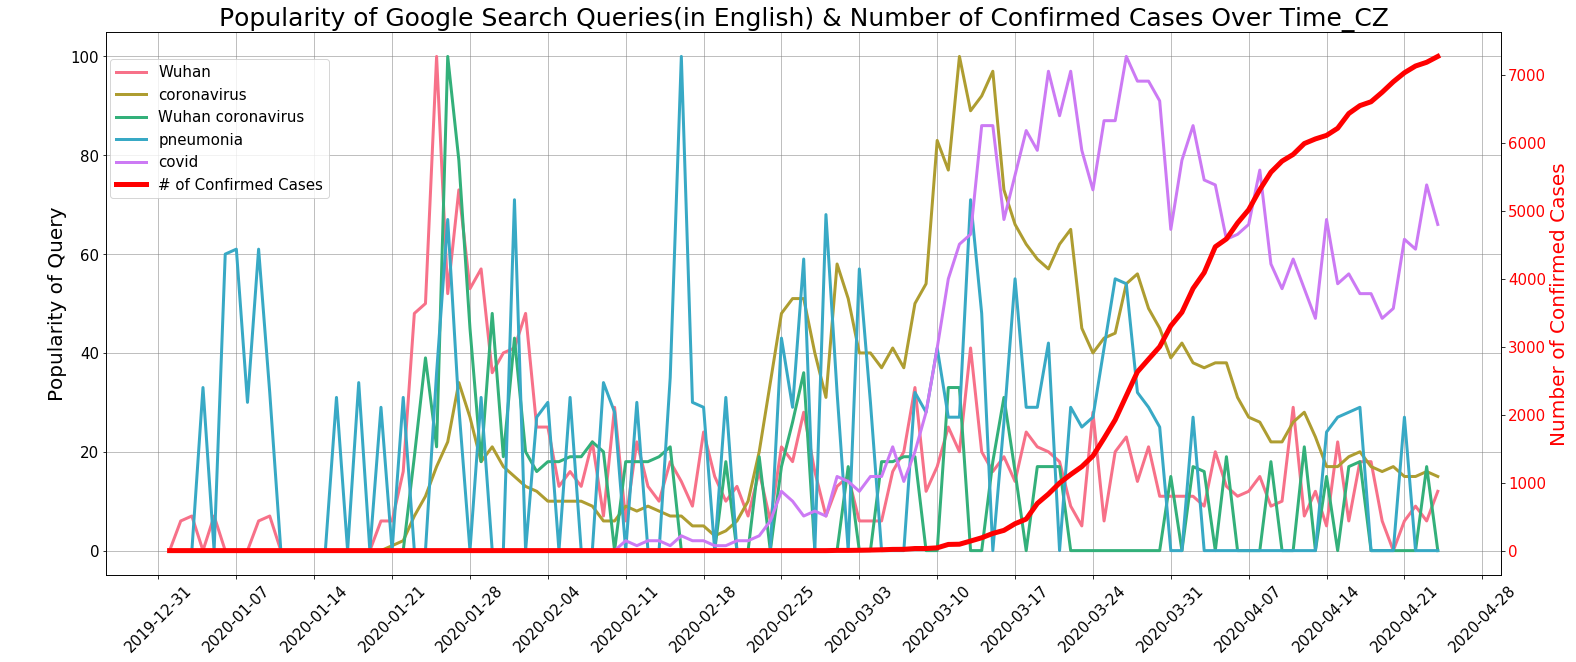

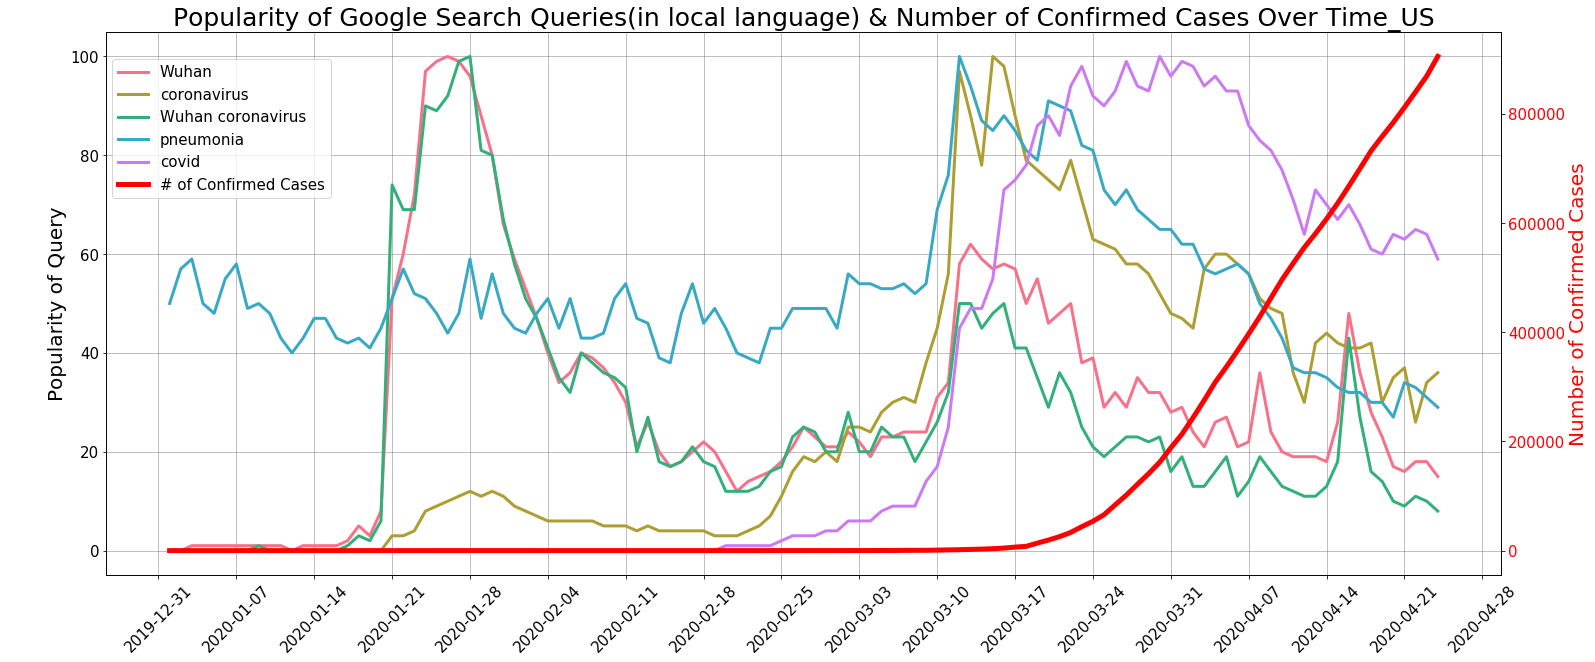

In [18]:
for key in single_google_trends_dict:
    popularity = single_google_trends_dict[key]
    t = popularity.index.values
    plot_GT_case_trends(t, popularity, key)
    if key != 'US':
        plot_GT_case_trends(t, popularity, key, local=False)

### Findings:
### 1. (Multiple) "Wuhan" and "pneumonial" are the most popular keywords searched before the outbreak in TW and KR while "coronavirus" is the most popular in IT, ES, CZ, and US
### 2. (Multi) "coronavirus"(in English) is the most popular search keyword among the others
### 3. (Single)  For local language keyword search, "Wuhan" and "pneumonial" shows an obvious increasing trend in TW and KR while only "Wuhan" shows the similar trend in IT, ES, CZ, and US
### 4. (Single) For English keyword search, "Wuhan" and "Wuhan coronavirus" both show an obvious increasing trend in all the countries
### 5. (Multi & Single) The popularity of "coronavirus"(in local lang) reached the highest point during 2020-03-31 ~ 2020-04-07 in both TW and KR, and reached the local peak in IT, ES, CZ ,and US (English keywords also show similar trends)

### 6. "確診“, ”症狀“, ”疫情“等相關搜尋字串是否考慮列入keyword?

In [15]:
pytrend = TrendReq(hl='en-US', tz=360)
pytrend.build_payload(kw_list=['武漢'], cat=0, timeframe='2020-01-01 2020-04-19', geo='TW', gprop='')
wuhan_related = pytrend.related_queries()
wuhan_related['武漢']['top'] 

query  value
0         肺炎 武漢    100
1         武漢 台灣     15
2      台灣 武漢 肺炎     14
3         武漢 疫情     13
4      武漢 肺炎 疫情     10
5         武漢 症狀      9
6      武漢 肺炎 症狀      8
7         武漢 確診      6
8      武漢 肺炎 最新      6
9      武漢 肺炎 確診      5
10        武漢 病毒      5
11     武漢 疫情 最新      3
12     武漢 肺炎 病徵      3
13  武漢 肺炎 疫情 最新      3
14     武漢 肺炎 人數      3
15        日本 武漢      3
16        武漢 日本      3
17     台灣 武漢 確診      3
18     武漢 肺炎 分佈      3
19     武漢 肺炎 日本      2
20  台灣 武漢 肺炎 確診      2
21        武漢 口罩      2
22        中國 武漢      2
23    武漢 肺炎 ptt      2
24        武漢 死亡      2

### Problems:

### 1. When building the country_dict, we need to manually search for the country names used in the dataset and modify accordingly
### --> Maybe use Regex to find similar country names? (ex: South Korea --> Korea, South)

### 2. 台灣的'武漢肺炎'、'新冠肺炎' & 捷克的'武漢肺炎'因搜尋資料不足皆為0

<img src="GT_Results/TW_Wuhan coronavirus(local).png">

<img src="GT_Results/TW_covid(local).png">

<img src="GT_Results/CZ_Wuhan coronavirus(local).png">

### 3. Keywords search results may exist some incorrect data

<img src="GT_Results/TW_Wuhan.png">

<img src="GT_Results/TW_Wuhan coronavirus.png">

<img src="GT_Results/IT_Wuhan coronavirus(local).png">

<img src="GT_Results/CZ_pneumonia(local).png">